In [24]:
import powerbox as pbox
import matplotlib.pyplot as plt
import numpy as np

In [25]:
%load_ext autoreload
%autoreload 2
%aimport

import matplotlib.pyplot as plt
import torch
import numpy as np
import gudhi as gd
from inverse_optim import gen_data
from inverse_optim import research_plot
# from inverse_optim import sancho
# import tadasets
# import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:
all-except-skipped

Modules to skip:



# Initial Tests

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


(512, 512)


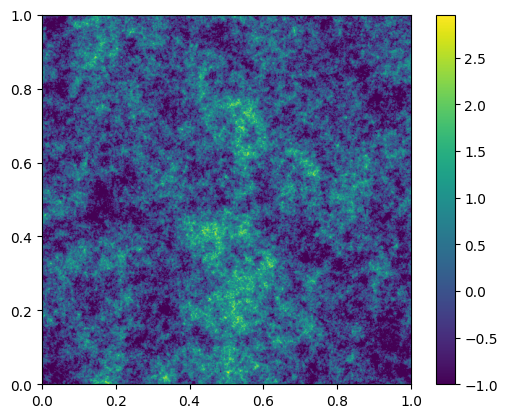

In [6]:
pb = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-2., # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1010,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)

print(pb.delta_x().shape)


plt.imshow(pb.delta_x(),extent=(0,1,0,1))
plt.colorbar()
plt.show()

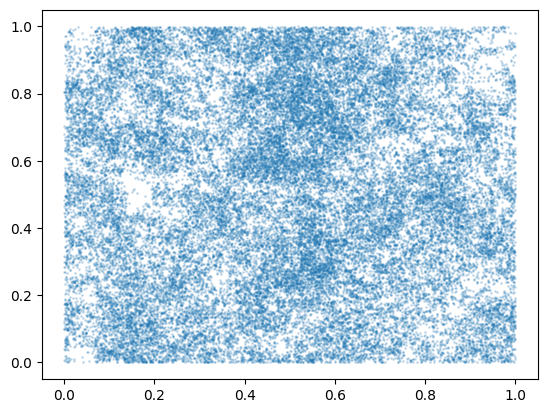

In [3]:
# Create a discrete sample using the PowerBox instance.
samples = pb.create_discrete_sample(nbar=50000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

# Plot the samples
plt.scatter(samples[:,0],samples[:,1], alpha=0.2,s=1)
plt.show()

In [4]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(samples, pb.boxlength,N=pb.N)

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:121: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


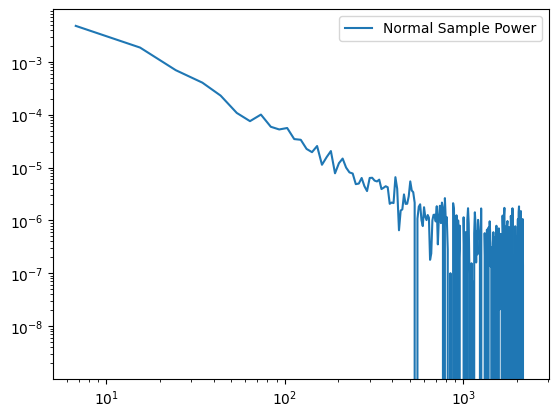

In [5]:
plt.plot(bins_samples, p_k_samples,label="Normal Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

In [7]:
pb.boxlength

1.0

# Attempt to recreate GRF

In [4]:
pb = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-2., # The power-spectrum
    boxlength = 2.0,           # Size of the box (sets the units of k in pk)
    seed = 1410,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples = pb.create_discrete_sample(nbar=5000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

pts = samples
samples = torch.tensor(samples)

print(len(samples))


20428


In [14]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_hybrid_dtm_pd(samples)

In [17]:
lr_list = np.linspace(0.1, 3, 3)
filtr="alpha_dtm"
# key_fn = lambda x: x[0] - x[1]
# if filtr=="alpha_dtm":
#         goal_pd[0] = torch.reshape(gen_data.tensor_sort(goal_pd[0], key_fn), (-1,))
#         goal_pd[1] = torch.reshape(gen_data.tensor_sort(goal_pd[1], key_fn), (-1,))
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=samples.size(dim=0), dim=2, epochs=300, decay_speed=30, sliced=True, filtr=filtr)

  2%|▏         | 6/300 [00:16<13:23,  2.73s/it]


KeyboardInterrupt: 

100%|██████████| 300/300 [00:32<00:00,  9.19it/s]


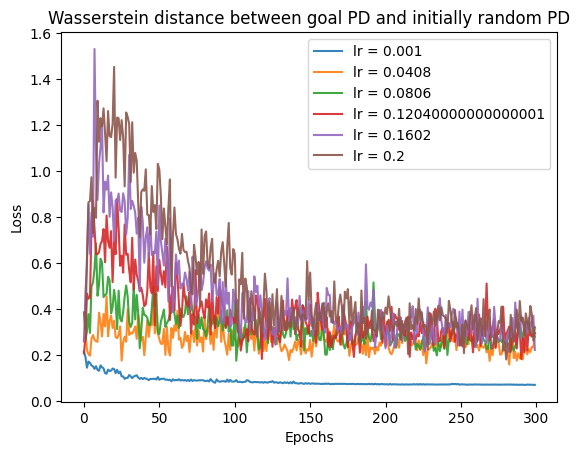

In [13]:
lr_list = np.linspace(0.001, 0.2, 6)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=samples.size(dim=0), dim=2, epochs=300, decay_speed=30, sliced=False, filtr="alpha_dtm")

In [7]:
filtr="alpha_dtm"
key_fn = lambda x: x[0] - x[1]
if filtr=="alpha_dtm":
        goal_pd[0] = torch.reshape(gen_data.tensor_sort(goal_pd[0], key_fn), (-1,))
        goal_pd[1] = torch.reshape(gen_data.tensor_sort(goal_pd[1], key_fn), (-1,))
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=samples.size(dim=0), lr=0.68, dim=2, epochs=300, decay_speed=30, sliced=0.2, filtr=filtr)

100%|██████████| 300/300 [18:03<00:00,  3.61s/it]


In [8]:
# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = pbox.get_power(pts, pb.boxlength, N=pb.N)
p_k_samples_new, bins_samples_new = pbox.get_power(final_pts.detach().numpy(), pb.boxlength, N=pb.N)

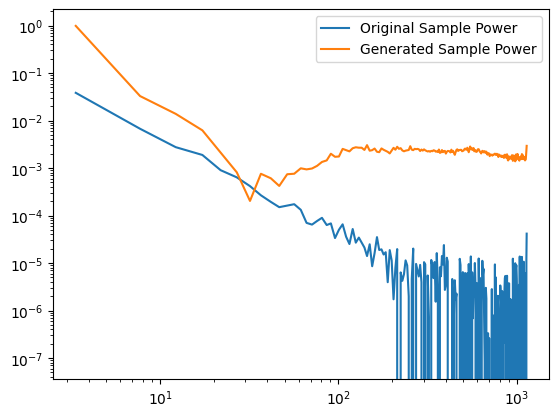

In [9]:
plt.plot(bins_samples, p_k_samples,label="Original Sample Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')

done with points
done with pkakaoints


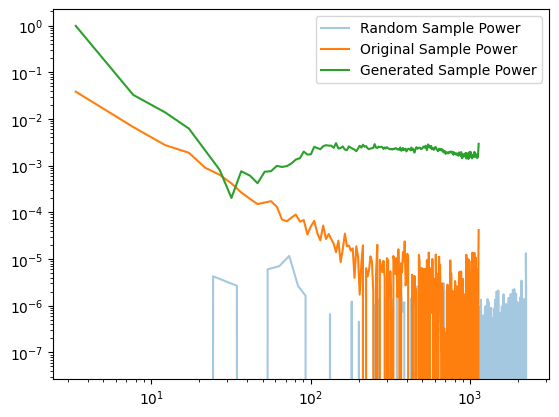

In [19]:
test_pts = np.random.random((samples.size(dim=0), 2))
print("done with points")
p_k_samples_test, bins_samples_test = pbox.get_power(test_pts, 1.0, N=pb.N)
print("done with pkakaoints")
plt.plot(bins_samples_test, p_k_samples_test,label="Random Sample Power", alpha=0.4)
plt.plot(bins_samples, p_k_samples,label="Original Sample Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Sample Power")

plt.legend()    
plt.xscale('log')
plt.yscale('log')

# Perturbing GRF's with Inverse Optimization (point sets)

20428


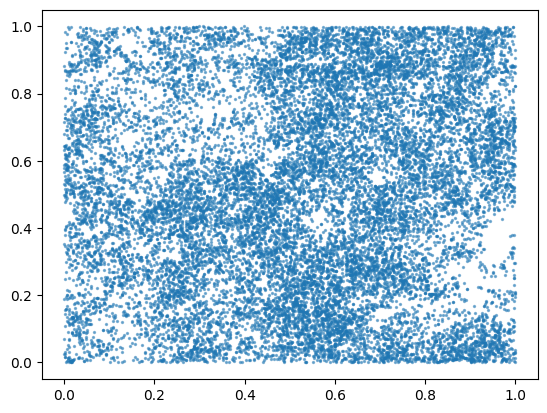

In [8]:
pb_target = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-2., # The power-spectrum
    boxlength = 1,           # Size of the box (sets the units of k in pk)
    seed = 1410,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples_target = pb_target.create_discrete_sample(nbar=20000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

samples_target = torch.tensor(samples_target)

print(len(samples_target))
# Plot the samples
plt.scatter(samples_target[:,0],samples_target[:,1], alpha=0.5, s=2)
plt.show()

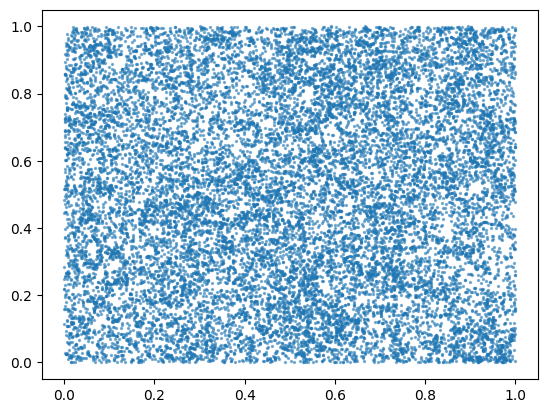

20047


In [9]:
pb_init = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-1., # The power-spectrum
    boxlength = 1,           # Size of the box (sets the units of k in pk)
    seed = 1410,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples_init = pb_init.create_discrete_sample(nbar=3800,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

# Plot the samples
plt.scatter(samples_init[:,0],samples_init[:,1], alpha=0.5, s=2)
plt.show()

print(len(samples_init))


In [10]:
print(len(samples_init))
print(samples_target.size(dim=0))

20047
20428


In [11]:
# Creation of the PD that we want to get to
goal_pd = gen_data.create_hybrid_dtm_pd(samples_target)
print(len(goal_pd))
print(goal_pd[0].size())
print(goal_pd[1].size())

2
torch.Size([20427, 2])
torch.Size([4783, 2])


/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:409: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|██████████| 200/200 [06:21<00:00,  1.91s/it]
/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:409: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|██████████| 200/200 [06:51<00:00,  2.06s/it]
/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:409: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|█

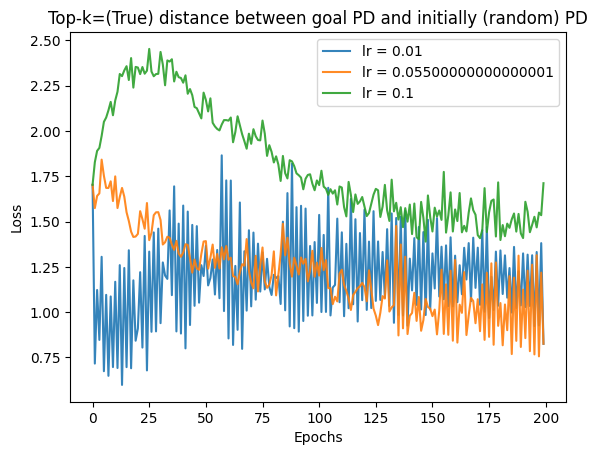

In [14]:
lr_list = np.linspace(0.01, 0.1, 3)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=samples_target.size(dim=0), dim=2, epochs=200, decay_speed=30, sliced=True, filtr="alpha_dtm", init_pts=samples_init)

/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:409: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":


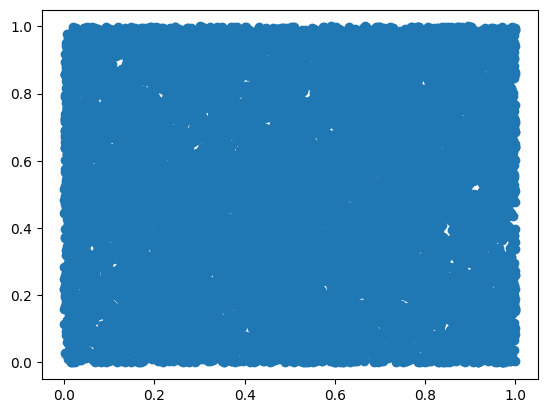

  5%|▍         | 14/300 [00:16<05:45,  1.21s/it]


KeyboardInterrupt: 

In [15]:
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=samples_target.size(dim=0), lr=0.05, dim=2, epochs=300, decay_speed=30, sliced=True, filtr="alpha_dtm", init_pts=samples_init)

In [24]:
# The number of grid points are also required when passing the samples
p_k_samples_target, bins_samples_target = pbox.get_power(samples_target.detach().numpy(), pb_target.boxlength, N=pb_target.N)
p_k_samples_init, bins_samples_init = pbox.get_power(samples_init, pb_init.boxlength, N=pb_init.N)
p_k_samples_new, bins_samples_new = pbox.get_power(final_pts.detach().numpy(), pb_target.boxlength, N=pb_target.N)

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:121: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


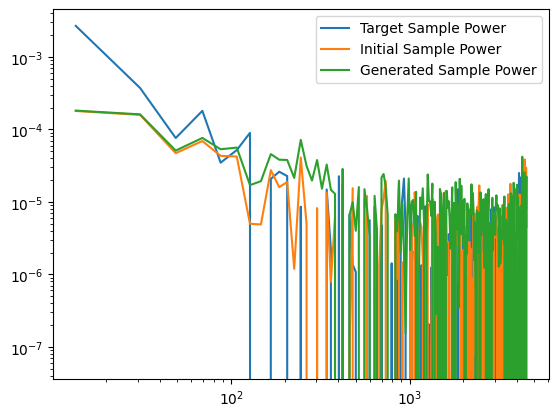

In [25]:
plt.plot(bins_samples_target, p_k_samples_target,label="Target Sample Power")
plt.plot(bins_samples_init, p_k_samples_init,label="Initial Sample Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')


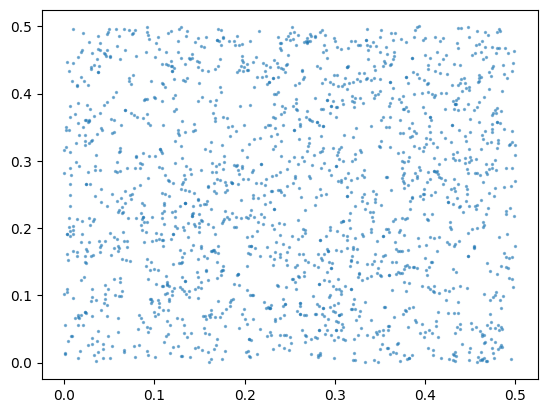

In [26]:
# Plot the samples
plt.scatter(final_pts.detach().numpy()[:,0],final_pts.detach().numpy()[:,1], alpha=0.5, s=2)
plt.show()

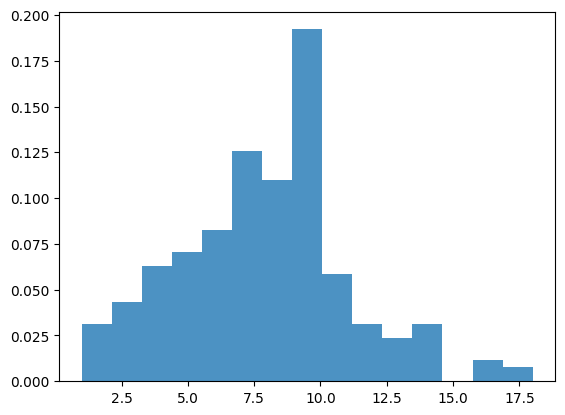

In [7]:
# Initial point set
nx = 2 ** 4
ny = 2 ** 4
boxlength= pb_init.boxlength
deltax = research_plot.check_gaussianity_for_pts(samples_init, nx=nx, ny=ny, boxlength=boxlength, bin_amount=15)

(16,)
(16,)
(1745, 2)


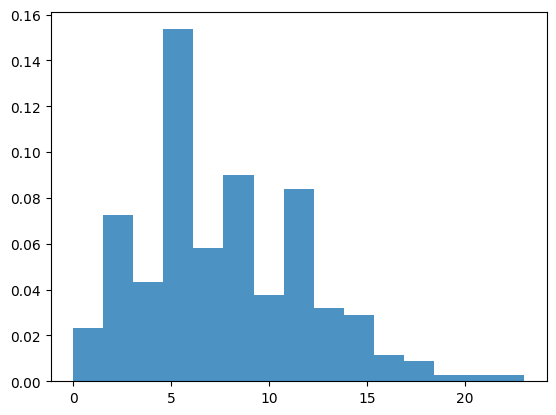

In [12]:
# Target point set
nx = 2 ** 4
ny = 2 ** 4

boxlength= pb_target.boxlength
deltax = research_plot.check_gaussianity_for_pts(samples_target.detach().numpy(), nx=nx, ny=ny, boxlength=boxlength, bin_amount=15)

(16,)
(16,)
(1773, 2)


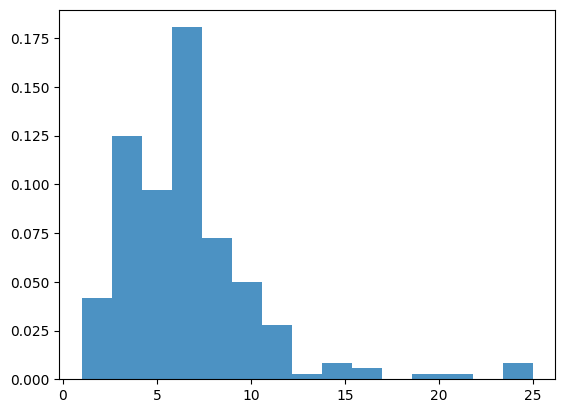

In [13]:
# New point set
nx = 2 ** 4
ny = 2 ** 4

boxlength= pb_target.boxlength
deltax = research_plot.check_gaussianity_for_pts(final_pts.detach().numpy(), nx=nx, ny=ny, boxlength=boxlength, bin_amount=15)

# Perturbing GRF's with Inverse Optimization (target is pure, approx is point)

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


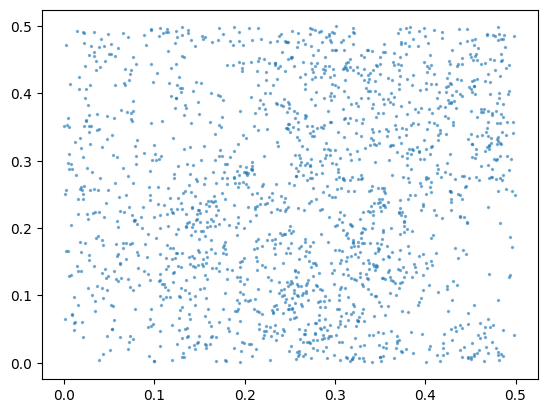

In [3]:
pb_target = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-2., # The power-spectrum
    boxlength = 0.5,           # Size of the box (sets the units of k in pk)
    seed = 1410,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples_target = pb_target.create_discrete_sample(nbar=7000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

samples_target = torch.tensor(samples_target)

# Plot the samples
plt.scatter(samples_target[:,0],samples_target[:,1], alpha=0.5, s=2)
plt.show()

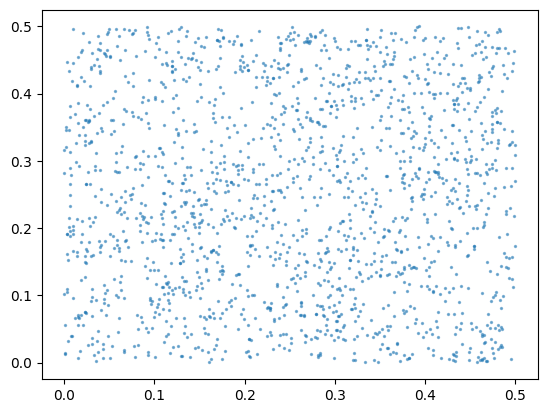

In [4]:
pb_init = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: 0.5*k**-1., # The power-spectrum
    boxlength = 0.5,           # Size of the box (sets the units of k in pk)
    seed = 1410,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples_init = pb_init.create_discrete_sample(nbar=1000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

# Plot the samples
plt.scatter(samples_init[:,0],samples_init[:,1], alpha=0.5, s=2)
plt.show()


In [5]:
# Creation of cubical complex out of field
nx, ny = pb_target.delta_x().shape
filt_values_target = pb_target.delta_x().flatten()
cc_target_field = gd.CubicalComplex(
    dimensions=[nx, ny],
    top_dimensional_cells=filt_values_target
)

# Persistence diagrams
# NOTE: The filtration values vary from -1 until infinity instead of 0. I do not know why yet (probably because of how the filtration values are simply defined). 
# However, I wouldn't expect this as the ensure_physical removes negatives densities right? (Well, it says OVERdensities?) Explanation needed from Matteo. 
# To make sure it is compatible with earlier persistence diagrams, everything is translated so that the smallest value is (0,0).
cc_target_field.compute_persistence()
goal_pd0 = torch.tensor(cc_target_field.persistence_intervals_in_dimension(0))
goal_pd1 = torch.tensor(cc_target_field.persistence_intervals_in_dimension(1))

# Removing infinities (for now)
for index, interval in enumerate(goal_pd0):
    if interval[1] == np.inf:
        goal_pd0 = np.delete(goal_pd0, index, axis=0)

for index, interval in enumerate(goal_pd1):
    if interval[1] == np.inf:
        goal_pd1 = np.delete(goal_pd1, index, axis=0)

goal_pd = [goal_pd0, goal_pd1]

/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:270: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|██████████| 100/100 [06:12<00:00,  3.72s/it]
/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:270: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|██████████| 100/100 [07:00<00:00,  4.21s/it]
/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:270: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|█

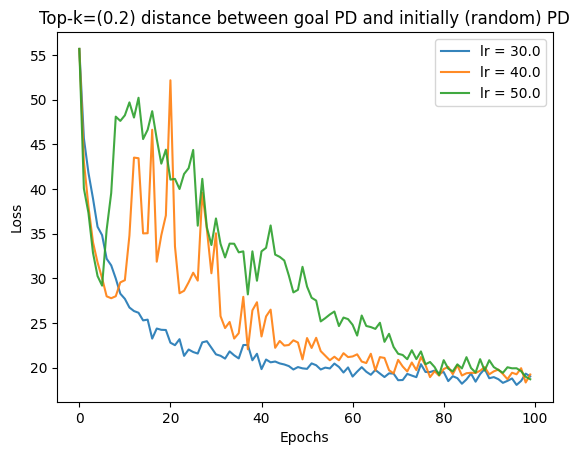

In [8]:
lr_list = np.linspace(30, 50, 3)
research_plot.research_lr(lr_list=lr_list, goal_pd=goal_pd, amount=torch.tensor(samples_init).size(dim=0), dim=2, epochs=100, decay_speed=30, sliced=0.2, filtr="alpha_dtm", init_pts=samples_init)

/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:270: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":


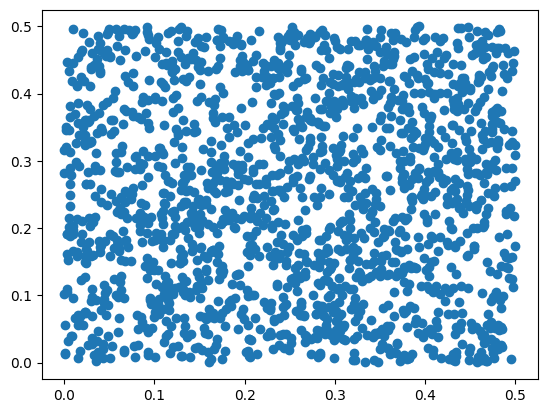

 33%|███▎      | 99/300 [03:31<07:10,  2.14s/it]

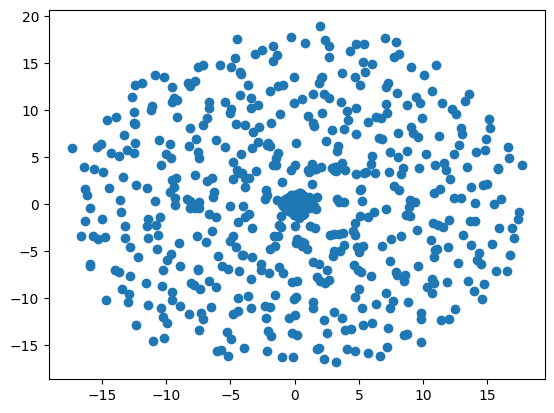

 66%|██████▋   | 199/300 [07:03<03:20,  1.98s/it]

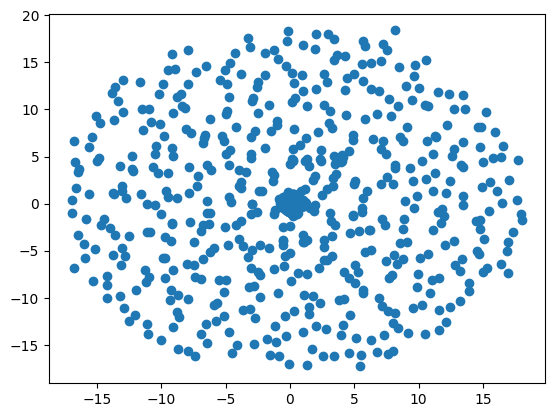

100%|█████████▉| 299/300 [10:25<00:01,  1.91s/it]

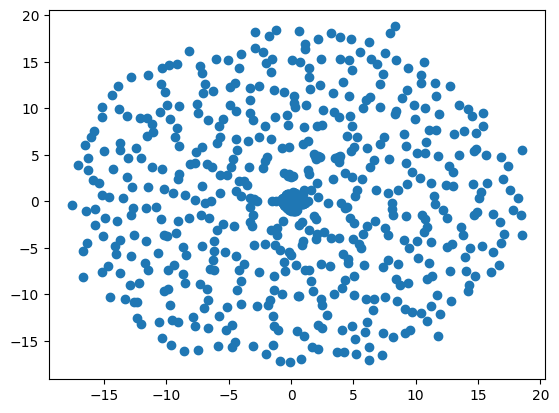

100%|██████████| 300/300 [10:27<00:00,  2.09s/it]


In [9]:
final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=samples_target.size(dim=0), lr=30, dim=2, epochs=300, decay_speed=30, sliced=0.2, filtr="alpha_dtm", init_pts=samples_init)

In [10]:
# The number of grid points are also required when passing the samples
p_k_samples_target, bins_samples_target = pbox.get_power(pb_target.delta_x(),pb_target.boxlength)
p_k_samples_init, bins_samples_init = pbox.get_power(samples_init, pb_init.boxlength, N=pb_init.N)
p_k_samples_new, bins_samples_new = pbox.get_power(final_pts.detach().numpy(), pb_target.boxlength, N=pb_target.N)

/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:212: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")
/Users/sliemela/Environments/inverse_optim_env/lib/python3.7/site-packages/powerbox/dft.py:121: UserWarning: You do not have pyFFTW installed. Installing it should give some speed increase.
  warnings.warn("You do not have pyFFTW installed. Installing it should give some speed increase.")


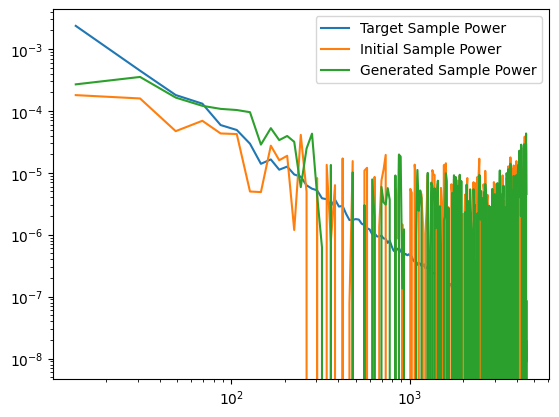

In [11]:
plt.plot(bins_samples_target, p_k_samples_target,label="Target Sample Power")
plt.plot(bins_samples_init, p_k_samples_init,label="Initial Sample Power")
plt.plot(bins_samples_new, p_k_samples_new,label="Generated Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')


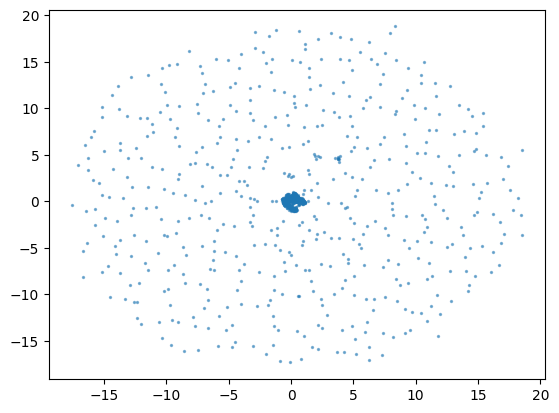

In [12]:
# Plot the samples
plt.scatter(final_pts.detach().numpy()[:,0],final_pts.detach().numpy()[:,1], alpha=0.5, s=2)
plt.show()

(16,)
(16,)
(1773, 2)


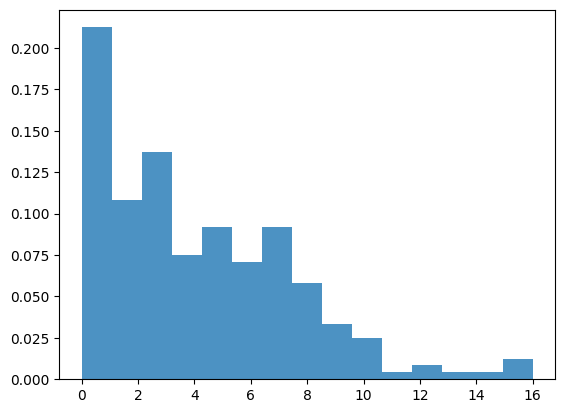

In [14]:
# Final point set
nx = 2 ** 4
ny = 2 ** 4
boxlength = pb_init.boxlength
deltax = research_plot.check_gaussianity_for_pts(final_pts.detach().numpy(), nx=nx, ny=ny, boxlength=boxlength, bin_amount=15)

# How well is the simulation?

To assess how well the simulation works, we will do the following:
1. Create 100 realisations of the same GRF (different seed everytime)
2. Create 100 corresponding simulations using the algorithm (either using a random or GRF input of some other power spectrum)
3. Calculate the pairwise distance of the GRF's power spectra.
4. Calculate the spread of the power spectra of the 100 realisations of step 1.
5. If the mean of what is calculated in step 3 is less than in step 4, we deem the simulation to be good enough.

Let us first create all the powerbox instances and the corresponding power spectra

In [26]:
# Parameters for the GRF that we want to target
a_target = 0.5
b_target = 2
grf_amount = 3

# Creation of the powerbox GRF's
pb_collection = []
for i in range(grf_amount):
    pb_collection.append(pbox.PowerBox(
        N=512,                              # Number of grid-points in the box
        dim=2,                              # 2D box
        pk = lambda k: a_target*k**-b_target, # The power-spectrum
        boxlength = 1.0,                    # Size of the box (sets the units of k in pk)
        seed = 1010+i,                      # Set a seed to ensure the box looks the same every time (optional)
        ensure_physical=True
    ))

# Creation of the target samples and calculation of corresponding power spectrum
target_samples_collection = []
ps_collection = []
nbar = 20000

for i in range(grf_amount):
    
    # Creation of target sample
    samples = pb_collection[i].create_discrete_sample(nbar=nbar,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )
    
    # Adding target sample as a tensor to the collection 
    target_samples_collection.append(torch.tensor(samples))

    # Calculating power spectrum and adding it to the collection
    ps_collection.append(pbox.get_power(samples, pb_collection[i].boxlength, N=pb_collection[i].N))

# Converting to numpy array for fasting access    
ps_collection = np.array(ps_collection)

# Creation of initial GRF
a_init = a_target
b_init = b_target - 1
pb_init = pbox.PowerBox(
    N=512,                     # Number of grid-points in the box
    dim=2,                     # 2D box
    pk = lambda k: a_init*k**-b_init, # The power-spectrum
    boxlength = 1.0,           # Size of the box (sets the units of k in pk)
    seed = 1410,               # Set a seed to ensure the box looks the same every time (optional)
    ensure_physical=True       # ** Ensure the delta_x is a physically valid over-density **
)


# Create a discrete sample using the PowerBox instance.
samples_init = pb_init.create_discrete_sample(nbar=3800,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   )

# Creation of the power spectrum
p_k_samples_init, bins_samples_init = pbox.get_power(samples_init, pb_init.boxlength, N=pb_init.N)

# SANITY CHECK:
print(len(target_samples_collection[1]))
print(len(samples_init))

20855
20047


Let us now generate the 100 corresponding simulations and their power spectra.
NOTE: We use the same learning rate everytime and use the results of the previous paragraph (`m=0.001, k=0.2, p=1.0, lr=1.26`)

In [30]:
gen_pts_collection = []
gen_ps_collection = []
filtr="alpha_dtm"
for i in range(grf_amount):

    # Creation of the persistence diagram
    goal_pd = gen_data.create_hybrid_dtm_pd(target_samples_collection[i])

    # # Reshape and order the pd by the persistence if top-k method is used
    # key_fn = lambda x: x[0] - x[1]
    # if filtr=="alpha_dtm":
    #     goal_pd[0] = torch.reshape(gen_data.tensor_sort(goal_pd[0], key_fn), (-1,))
    #     goal_pd[1] = torch.reshape(gen_data.tensor_sort(goal_pd[1], key_fn), (-1,))

    # Generation of point set
    final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=target_samples_collection[i].size(dim=0),\
                                        lr=1, dim=2, epochs=300, decay_speed=30, \
                                            sliced=True, filtr=filtr, init_pts=samples_init)
    # final_pts = gen_data.generate_data(goal_pd=goal_pd, amount=target_samples_collection[i].size(dim=0),\
    #                                     lr=0.68, dim=2, epochs=300, decay_speed=30, \
    #                                         sliced=0.2, filtr=filtr, init_pts="random")
    gen_pts_collection.append(final_pts)

    # Creation of power spectrum 
    gen_ps_collection.append(pbox.get_power(final_pts.detach().numpy(), pb_collection[i].boxlength, N=pb_collection[i].N))


# Converting to numpy array for fasting access    
gen_ps_collection = np.array(gen_ps_collection)

/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:409: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|██████████| 300/300 [05:53<00:00,  1.18s/it]
/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:409: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|██████████| 300/300 [05:56<00:00,  1.19s/it]
/Users/sliemela/Google Drive/Education/UvA/Double Master/Thesis/masterthesis/Programming/Inverse Optimization/src/inverse_optim/gen_data.py:409: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if init_pts == "random":
100%|█

Let us now plot the different power spectra

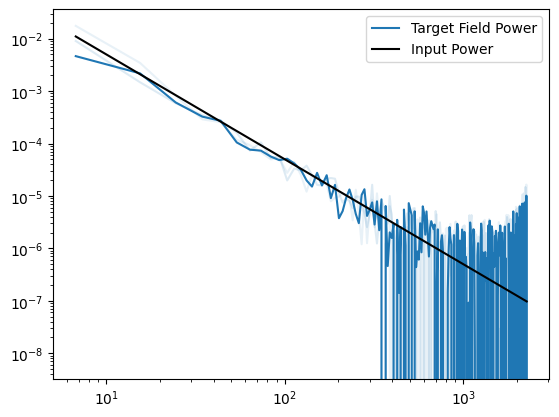

In [28]:
pure_ps = pbox.get_power(pb_collection[0].delta_x(),pb_collection[0].boxlength)
for i in range(grf_amount):
    if i == 0:
        plt.plot(ps_collection[i, 1], ps_collection[i, 0],color='C0',label="Target Field Power")
    else:        
        plt.plot(ps_collection[i, 1], ps_collection[i, 0], color='C0',alpha=0.05*(i+1))
        
plt.plot(pure_ps[1], a_target*pure_ps[1]**-b_target, color='k',label="Input Power")
plt.legend()
plt.xscale('log')
plt.yscale('log')

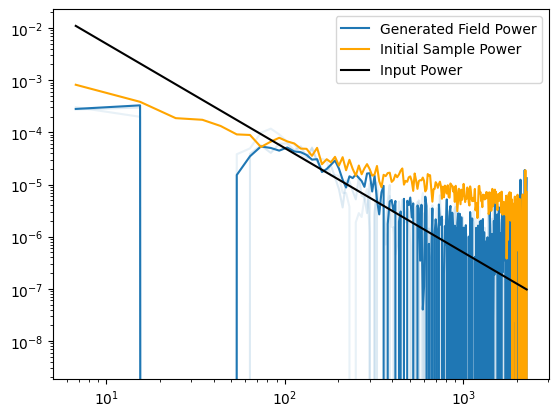

In [29]:
pure_ps = pbox.get_power(pb_collection[0].delta_x(),pb_collection[0].boxlength)
for i in range(grf_amount):
    if i == 0:
        plt.plot(gen_ps_collection[i, 1], gen_ps_collection[i, 0],color='C0',label="Generated Field Power")
    else:        
        plt.plot(gen_ps_collection[i, 1], gen_ps_collection[i, 0], color='C0',alpha=0.05*(i+1))
        
plt.plot(bins_samples_init, p_k_samples_init, color="orange", label="Initial Sample Power")
plt.plot(pure_ps[1], a_target*pure_ps[1]**-b_target, color='k',label="Input Power")
plt.legend()
plt.xscale('log')
plt.yscale('log')

Let us now calculate the spread of the target GRF's and the pairwise distance of the target and generated GRF's